<a href="https://colab.research.google.com/github/alexmjn/DS-Unit-1-Sprint-2-Statistics/blob/master/module2/LS_DS_122_Sampling_Confidence_Intervals_and_Hypothesis_Testing_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignment - Build a confidence interval

A confidence interval refers to a neighborhood around some point estimate, the size of which is determined by the desired p-value. For instance, we might say that 52% of Americans prefer tacos to burritos, with a 95% confidence interval of +/- 5%.

52% (0.52) is the point estimate, and +/- 5% (the interval $[0.47, 0.57]$) is the confidence interval. "95% confidence" means a p-value $\leq 1 - 0.95 = 0.05$.

In this case, the confidence interval includes $0.5$ - which is the natural null hypothesis (that half of Americans prefer tacos and half burritos, thus there is no clear favorite). So in this case, we could use the confidence interval to report that we've failed to reject the null hypothesis.

But providing the full analysis with a confidence interval, including a graphical representation of it, can be a helpful and powerful way to tell your story. Done well, it is also more intuitive to a layperson than simply saying "fail to reject the null hypothesis" - it shows that in fact the data does *not* give a single clear result (the point estimate) but a whole range of possibilities.

How is a confidence interval built, and how should it be interpreted? It does *not* mean that 95% of the data lies in that interval - instead, the frequentist interpretation is "if we were to repeat this experiment 100 times, we would expect the average result to lie in this interval ~95 times."

For a 95% confidence interval and a normal(-ish) distribution, you can simply remember that +/-2 standard deviations contains 95% of the probability mass, and so the 95% confidence interval based on a given sample is centered at the mean (point estimate) and has a range of +/- 2 (or technically 1.96) standard deviations.

Different distributions/assumptions (90% confidence, 99% confidence) will require different math, but the overall process and interpretation (with a frequentist approach) will be the same.

Your assignment - using the data from the prior module ([congressional voting records](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records)):


### Confidence Intervals:
1. Generate and numerically represent a confidence interval
2. Graphically (with a plot) represent the confidence interval
3. Interpret the confidence interval - what does it tell you about the data and its distribution?

### Chi-squared tests:
4. Take a dataset that we have used in the past in class that has **categorical** variables. Pick two of those categorical variables and run a chi-squared tests on that data
  - By hand using Numpy
  - In a single line using Scipy


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import t, ttest_ind, ttest_1samp, chisquare
from scipy.stats.distributions import chi2

In [3]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data

--2019-12-10 21:11:21--  https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18171 (18K) [application/x-httpd-php]
Saving to: ‘house-votes-84.data’

house-votes-84.data 100%[===================>]  17.75K  --.-KB/s    in 0.06s   

2019-12-10 21:11:21 (287 KB/s) - ‘house-votes-84.data’ saved [18171/18171]



In [4]:
# Read in the congressional data
voting_data = pd.read_csv('house-votes-84.data', 
                          header = None, 
                          names = ['party','handicapped-infants','water-project',
                          'budget','physician-fee-freeze', 'el-salvador-aid',
                          'religious-groups','anti-satellite-ban',
                          'aid-to-contras','mx-missile','immigration',
                          'synfuels', 'education', 'right-to-sue','crime','duty-free',
                          'south-africa'], na_values = "?")
print(voting_data.shape)
voting_data.head()

(435, 17)


,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
0,republican,n,y,n,y,y,y,n,n,n,y,NaN,y,y,y,n,y
1,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,NaN
2,democrat,NaN,y,y,NaN,y,y,n,n,n,n,y,n,y,y,n,n
3,democrat,n,y,y,n,NaN,y,n,n,n,n,y,n,y,n,n,y
4,democrat,y,y,y,n,y,y,n,n,n,n,y,NaN,y,y,y,y


In [0]:
# I split the data by party and set NaN values equal to .5.
# In this data, it seems logical to conclude that absention communicates something
# in between a "yes" and "no" vote. In a more longform project, this would be 
# worth detailed research.
voting_data = voting_data.replace({'n': 0, 'y':1, np.NaN: .5})
dem = voting_data[voting_data['party'] == 'democrat']
rep = voting_data[voting_data['party'] == 'republican']

In [16]:
dem.head()

,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
2,democrat,0.5,1.0,1.0,0.5,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,democrat,0.0,1.0,1.0,0.0,0.5,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,democrat,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.5,1.0,1.0,1.0,1.0
5,democrat,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
6,democrat,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,1.0,1.0,1.0


In [17]:
dem.describe()

,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
count,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,267.00000,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000,267.000000
mean,0.601124,0.501873,0.878277,0.067416,0.228464,0.477528,0.764045,0.823970,0.73970,0.471910,0.505618,0.168539,0.301498,0.355805,0.629213,0.801498
std,0.481889,0.473941,0.317379,0.235772,0.407005,0.491909,0.416460,0.376602,0.41882,0.496375,0.489520,0.351772,0.444174,0.469756,0.468128,0.287453
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.750000,1.000000,0.50000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000
50%,1.000000,0.500000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.00000,0.000000,0.500000,0.000000,0.000000,0.000000,1.000000,1.000000
75%,1.000000,1.000000,1.000000,0.000000,0.250000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [0]:
def confidence_interval(data, confidence = .95):
  data = np.array(data)
  mean = np.mean(data)
  n = len(data)
  stderr = np.std(data, ddof=1)/np.sqrt(n)
  t = stats.t.ppf((1 + confidence)/2.0, n-1)
  moe = stderr * t
  return (mean, mean - moe, mean + moe)

In [21]:
confidence_interval(dem["water-project"])

(0.50187265917603, 0.44476456249791607, 0.5589807558541439)

We are 95% confident that the true mean of democratic support for the water project is between 44.5% and 55.9%. (That is: 95% of samples that product this result will be drawn from a population mean between 44.5 and 55.9%.

In [0]:
def plot_ci(data):
  sns.distplot(data)
  ci = confidence_interval(data)
  plt.axvline(x = ci[1], color = 'green')
  plt.axvline(x = ci[2], color = 'green')
  plt.axvline(x = ci[0], color = 'red')


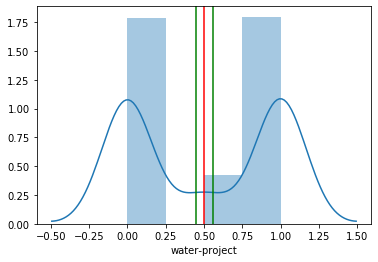

In [22]:
# After plotting, we can see the confidence interval 
# represented with the two green lines and the 
# sample mean represented with the red line.
plot_ci(dem["water-project"])

In [23]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv

--2019-12-10 22:20:06--  https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84199 (82K) [application/x-httpd-php]
Saving to: ‘winequality-red.csv’

winequality-red.csv 100%[===================>]  82.23K  --.-KB/s    in 0.1s    

2019-12-10 22:20:07 (638 KB/s) - ‘winequality-red.csv’ saved [84199/84199]



In [26]:
wine_quality = pd.read_csv("winequality-red.csv", sep = ";")
wine_quality.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [0]:
wine_quality['alcohol_bins'] = pd.qcut(wine_quality['alcohol'], 5)

In [36]:
crosstab = pd.crosstab(wine_quality['quality'], wine_quality['alcohol_bins'], margins = True)
crosstab

alcohol_bins,"(8.399000000000001, 9.5]","(9.5, 9.9]","(9.9, 10.5]","(10.5, 11.3]","(11.3, 14.9]",All
quality,,,,,,
3,2,3,2,3,0,10
4,12,12,10,12,7,53
5,298,148,129,76,30,681
6,120,72,136,154,156,638
7,4,7,26,56,106,199
8,0,1,1,3,13,18
All,436,243,304,304,312,1599


# Chi-Squared Test

Now that I have categorical variables, I will run a chi-squared test to assess the hypothesis that alcohol concentration (as measured by placement in quintiles) and assessed wine quality are dependent against the null hypothesis that they are independent.

Eyeballing the crosstab leaves me reasonably certain there is a relationship, but let's formally evaluate that hypothesis.



In [0]:
observed_data = pd.crosstab(wine_quality['quality'], wine_quality['alcohol_bins'])

In [0]:
three = crosstab.iloc[0][0:5].values
four = crosstab.iloc[1][0:5].values
five = crosstab.iloc[2][0:5].values
six = crosstab.iloc[3][0:5].values
seven = crosstab.iloc[4][0:5].values
eight = crosstab.iloc[5][0:5].values

In [39]:
# Pull row and column sums in order to construct a table of expected 
# values based on totals. We'll then compare this table with observed values
# to calculate the chi-squared statistic.
row_sums = crosstab.iloc[0:6, 5].values
col_sums = crosstab.iloc[6, 0:5].values
print(row_sums)
print(col_sums)

[ 10  53 681 638 199  18]
[436 243 304 304 312]


In [42]:
total = crosstab.loc['All', 'All']
expected = []
for i in range(len(row_sums)):
  expected_row = []
  for column in col_sums:
    expected_value = column * row_sums[i]/total
    expected_row.append(expected_value)
  expected.append(expected_row)
expected = np.array(expected)
print(expected.shape)
print(observed_data.shape)

(6, 5)
(6, 5)


In [44]:
expected

array([[  2.72670419,   1.51969981,   1.90118824,   1.90118824,
          1.95121951],
       [ 14.45153221,   8.05440901,  10.07629769,  10.07629769,
         10.34146341],
       [185.68855535, 103.49155722, 129.47091932, 129.47091932,
        132.87804878],
       [173.96372733,  96.95684803, 121.29580988, 121.29580988,
        124.48780488],
       [ 54.26141338,  30.24202627,  37.83364603,  37.83364603,
         38.82926829],
       [  4.90806754,   2.73545966,   3.42213884,   3.42213884,
          3.51219512]])

In [47]:
observed = observed_data.values
observed

array([[  2,   3,   2,   3,   0],
       [ 12,  12,  10,  12,   7],
       [298, 148, 129,  76,  30],
       [120,  72, 136, 154, 156],
       [  4,   7,  26,  56, 106],
       [  0,   1,   1,   3,  13]])

In [48]:
# Now that we have our arrays, numpy array broadcasting
# lets us perform element-wise operation to calculate
# our chi-squared statistic.

chi_squared = ((observed - expected) ** 2 / (expected)).sum()
print(f"Chi-Squared: {chi_squared}")

Chi-Squared: 465.01907878270663


In [49]:
# Calculate degrees of freedom:
dof = (len(row_sums) - 1) * (len(col_sums) - 1)
print(f"Degrees of Freedom: {dof}")

Degrees of Freedom: 20


From the Chi^2 lookup table, we can assess whether this result is significant. With 20 degrees of freedom, a chi-squared statistic of 31.41 is significant at .05 and 37.57 is significant at .01. The observed chi-squared statistic of 465.0 is therefore significant, and we reject the null hypothesis of independence and conclude that ther eis a dependent relationship. This manual analysis should match the results we get from scipy.

In [50]:
chi_squared, p_value, dof, expected = stats.chi2_contingency(observed)
print(f"Chi-Squared: {chi_squared}")
print(f"p-value: {p_value}")
print(f"Degrees of Freedom: {dof}") 
print("Expected: \n", np.array(expected))

Chi-Squared: 465.01907878270663
p-value: 5.993233494929643e-86
Degrees of Freedom: 20
Expected: 
 [[  2.72670419   1.51969981   1.90118824   1.90118824   1.95121951]
 [ 14.45153221   8.05440901  10.07629769  10.07629769  10.34146341]
 [185.68855535 103.49155722 129.47091932 129.47091932 132.87804878]
 [173.96372733  96.95684803 121.29580988 121.29580988 124.48780488]
 [ 54.26141338  30.24202627  37.83364603  37.83364603  38.82926829]
 [  4.90806754   2.73545966   3.42213884   3.42213884   3.51219512]]


We observe an identical chi-squared value, letting us know that the calculations above were done correctly. The p-value is 5.99 * 10^-86: these results would essentially never occur by chance. From looking at the table as compared to expectations, we can conclude that there is a positive association between alcohol content and rating of the wine.

## Stretch goals:

1. Write a summary of your findings, mixing prose and math/code/results. *Note* - yes, this is by definition a political topic. It is challenging but important to keep your writing voice *neutral* and stick to the facts of the data. Data science often involves considering controversial issues, so it's important to be sensitive about them (especially if you want to publish).
2. Apply the techniques you learned today to your project data or other data of your choice, and write/discuss your findings here.
3. Refactor your code so it is elegant, readable, and can be easily run for all issues.

## Resources

- [Interactive visualize the Chi-Squared test](https://homepage.divms.uiowa.edu/~mbognar/applets/chisq.html)
- [Calculation of Chi-Squared test statistic](https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test)
- [Visualization of a confidence interval generated by R code](https://commons.wikimedia.org/wiki/File:Confidence-interval.svg)
- [Expected value of a squared standard normal](https://math.stackexchange.com/questions/264061/expected-value-calculation-for-squared-normal-distribution) (it's 1 - which is why the expected value of a Chi-Squared with $n$ degrees of freedom is $n$, as it's the sum of $n$ squared standard normals)